## 1. Install Packages

In [79]:
#Install packages
install.packages(c("dplyr","ggplot2", "ordinal","emmeans","broom","writexl"))

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



# 2. Data Analysis

## Read Data

In [80]:
#This is the data that shows judgements for the survey
df <- read.csv("https://raw.githubusercontent.com/MatthewCGalbraith/GrammarHCI/refs/heads/main/scoresnoncondensedlong.csv")

## Import Libraries

In [81]:
library(dplyr)
library(ggplot2)
library(ordinal)
library(emmeans)
library(readr)
library(tidyr)
library(grid)
library(scales)

## RFC

### Setup Data

In [82]:
# Read the same file you linked
df <- read.csv("https://raw.githubusercontent.com/MatthewCGalbraith/GrammarHCI/refs/heads/main/scoresnoncondensedlong.csv",
               na.strings = c("", "NA"))

# Keep only RFC items
df_rfc <- df %>% filter(grepl("^RFC[A-D]", Question))

# Coerce Scores to character then keep only Likert 1–5; drop 0 / NA
df_rfc <- df_rfc %>%
  mutate(Scores = as.character(Scores)) %>%
  filter(Scores %in% c("1","2","3","4","5")) %>%
  mutate(Scores = ordered(Scores, levels = c("1","2","3","4","5")))

# Map item prefix to condition
df_rfc <- df_rfc %>%
  mutate(
    condition = case_when(
      grepl("^RFCA", Question) ~ "Int",
      grepl("^RFCB", Question) ~ "RFCi",
      grepl("^RFCC", Question) ~ "RFCp",
      grepl("^RFCD", Question) ~ "Dec",
      TRUE ~ NA_character_
    ),
    # Set publication order for your hierarchy display
    condition = factor(condition, levels = c("Int","RFCp","Dec","RFCi"))
  )

# Optional: rename item labels for plotting/tables while keeping original Question
df_rfc <- df_rfc %>%
  mutate(Question_renamed = Question |>
           sub("^RFCA", "Int",  x = _) |>
           sub("^RFCB", "RFCi", x = _) |>
           sub("^RFCC", "RFCp", x = _) |>
           sub("^RFCD", "Dec",  x = _))


### Frequency Table


In [83]:
# df_frequency_table <- df_rfc %>%
#   group_by(condition, Scores) %>%
#   summarise(Frequency = n(), .groups = 'drop')

# print(df_frequency_table)

### Stacked Bar Chart


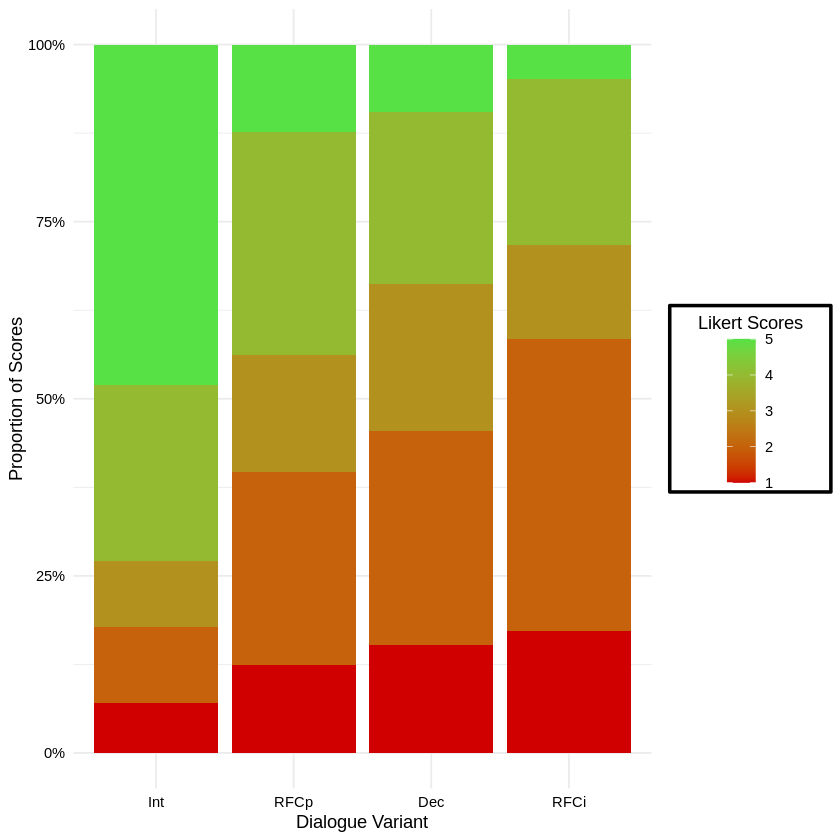

In [84]:
# Calculate proportions of Scores within each condition
df_proportions <- df_rfc %>%
  group_by(condition, Scores) %>%
  summarise(count = n(), .groups = 'drop') %>%
  group_by(condition) %>%
  mutate(proportion = count / sum(count)) %>%
  ungroup()

# Convert Scores to numeric for gradient scale
df_proportions$Scores_numeric <- as.numeric(as.character(df_proportions$Scores))

# Create the 100% stacked bar chart with continuous gradient
ggplot(df_proportions, aes(x = condition, y = proportion, fill = Scores_numeric)) +
  geom_bar(stat = "identity", position = "fill") +
  # geom_text(aes(label = count), position = position_stack(vjust = 0.5), color = "black", size = 4) + # Added count labels
  scale_y_continuous(labels = scales::percent) +
  labs(
    title = NULL, # Removed the title
    x = "Dialogue Variant",
    y = "Proportion of Scores",
    fill = "Likert Scores"
  ) +
  # Continuous color scale from red (1) to green (5)
  scale_fill_gradient(low = "#d00000", high = "#57e145",
                      breaks = c(1, 2, 3, 4, 5),
                      labels = c("1", "2", "3", "4", "5")) +
  theme_minimal() +
  theme(
    axis.text.x = element_text(angle = 0, hjust = 0.5, color = "black"), # Horizontal and black
    axis.text.y = element_text(color = "black"), # Y-axis text black
    axis.title.x = element_text(color = "black"), # X-axis title black
    axis.title.y = element_text(color = "black"), # Y-axis title black
    legend.position = "right",
    legend.title = element_text(color = "black", hjust = 0.5), # Centered legend title
    legend.text = element_text(color = "black"), # Legend text black
    legend.background = element_rect(color = "black", linewidth = 1), # Black box around legend
    legend.justification = "center", # Center the legend vertically if position is right/left
    legend.box.just = "center" # Justify individual legends within box
  )

In [85]:
### EMMeans Analysis


### EMMeans Analysis


In [86]:
# Proportional-odds cumulative logit model by condition
m_rfc <- clm(Scores ~ condition, data = df_rfc, link = "logit", Hess = TRUE)

# Latent-scale condition means with 95% CI
emm_latent <- emmeans(m_rfc, ~ condition, mode = "latent")
latent_tbl <- as.data.frame(summary(emm_latent, infer = c(TRUE, TRUE)))
write.csv(latent_tbl, "RFC_condition_latent_emmeans.csv", row.names = FALSE)


### Pairwise Comparison


In [87]:
# All pairwise condition contrasts on latent scale with adjustments
pairs_holm  <- pairs(emm_latent, adjust = "holm")

pairs_holm_tbl  <- as.data.frame(summary(pairs_holm))

write.csv(pairs_holm_tbl,  "RFC_condition_pairs_holm.csv",  row.names = FALSE)

### Pairwise Comparison Estimates


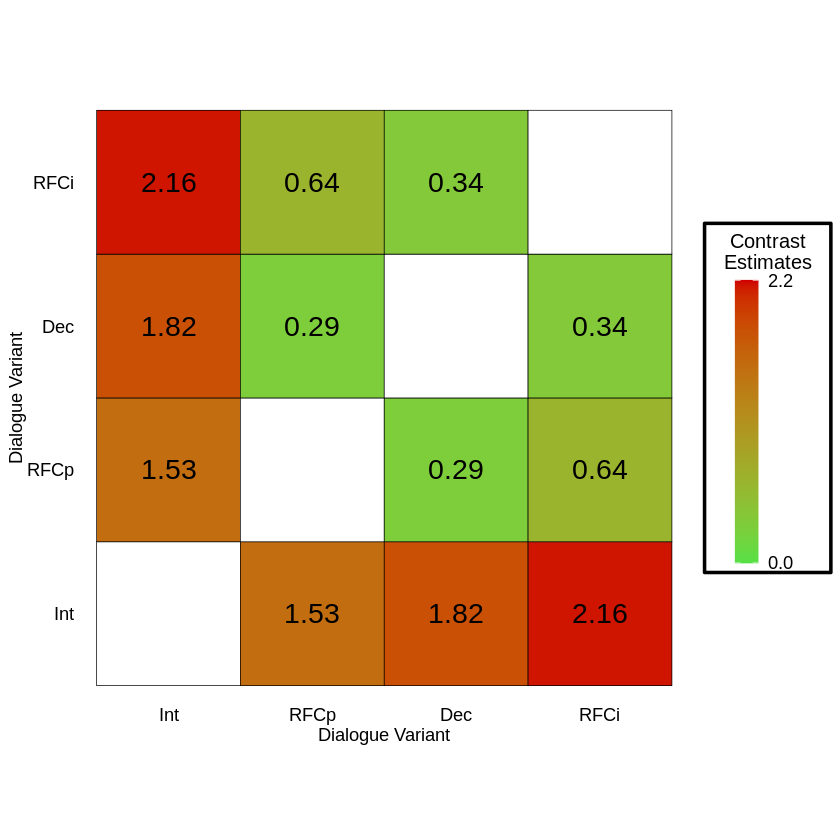

In [88]:
results <- summary(pairs_holm, adjust = "holm")
df_contrasts <- as.data.frame(results)

format_pvalue <- function(p_value) {
  if (p_value < 0.001) {
    return("<0.001***")
  } else if (p_value < 0.01) {
    return("<0.01**")
  } else if (p_value < 0.05) {
    return("<0.05*")
  } else {
    return(paste0("", round(p_value, 4)))
  }
}

df_pairwise <- data.frame(
  Effect = df_contrasts$contrast,
  Coefficient = round(df_contrasts$estimate, 2),
  `Std. Error` = round(df_contrasts$SE, 2),
  `Z Value` = round(df_contrasts$z.ratio, 2),
  `P Value` = sapply(df_contrasts$p.value, format_pvalue),
  Odds_Ratio = round(exp(df_contrasts$estimate), 2),
  CI_Lower = round(exp(df_contrasts$estimate - 1.96 * df_contrasts$SE), 2),
  CI_Upper = round(exp(df_contrasts$estimate + 1.96 * df_contrasts$SE), 2)
)

all_conditions <- c("Int","RFCp","Dec","RFCi")

df_heat_prep <- df_pairwise %>%
  mutate(Effect = as.character(Effect)) %>%
  separate(Effect, into = c("Condition1", "Condition2"), sep = " - ", remove = FALSE) %>%
  rename(estimate = Coefficient) %>%
  select(Condition1, Condition2, estimate)

df_heat_full <- expand.grid(
  Condition1 = all_conditions,
  Condition2 = all_conditions,
  stringsAsFactors = FALSE
) %>%
  left_join(df_heat_prep, by = c("Condition1", "Condition2")) %>%
  mutate(
    estimate = ifelse(
      is.na(estimate),
      df_heat_prep$estimate[
        match(
          paste(Condition2, Condition1, sep = " - "),
          paste(df_heat_prep$Condition1, df_heat_prep$Condition2, sep = " - ")
        )
      ],
      estimate
    )
  ) %>%
  mutate(estimate = ifelse(Condition1 == Condition2, NA, estimate)) %>%
  mutate(
    x = factor(Condition1, levels = all_conditions),
    y = factor(Condition2, levels = all_conditions)
  )


ggplot(df_heat_full, aes(x = x, y = y, fill = estimate)) +
  geom_tile(color = "black") +
  geom_text(aes(label = round(estimate, 2)), size = 6, na.rm = TRUE) +
  scale_fill_gradient(
    name = "Contrast\nEstimates",
    low = "#57e145",
    high = "#d00000",
    limits = c(0.0, 2.2),
    oob = scales::squish,
    na.value = "white",
    breaks = c(0.0, 2.2),
    labels = c("0.0", "2.2")
  ) +
  coord_fixed() +
  labs(
    x = "Dialogue Variant",
    y = "Dialogue Variant"
  ) +
  theme_minimal() +
  theme(
    panel.grid = element_blank(),
    axis.text = element_text(size = 11, color = "black"),
    legend.title = element_text(size = 12, hjust = 0.5),
    legend.text = element_text(size = 11),
    legend.background = element_rect(color = "black", linewidth = 1),
    legend.key.height = unit(1.2, "cm"),
    legend.key.width = unit(0.5, "cm"),
    legend.spacing.y = unit(0.2, "cm")
  )

### EMMeans Plot


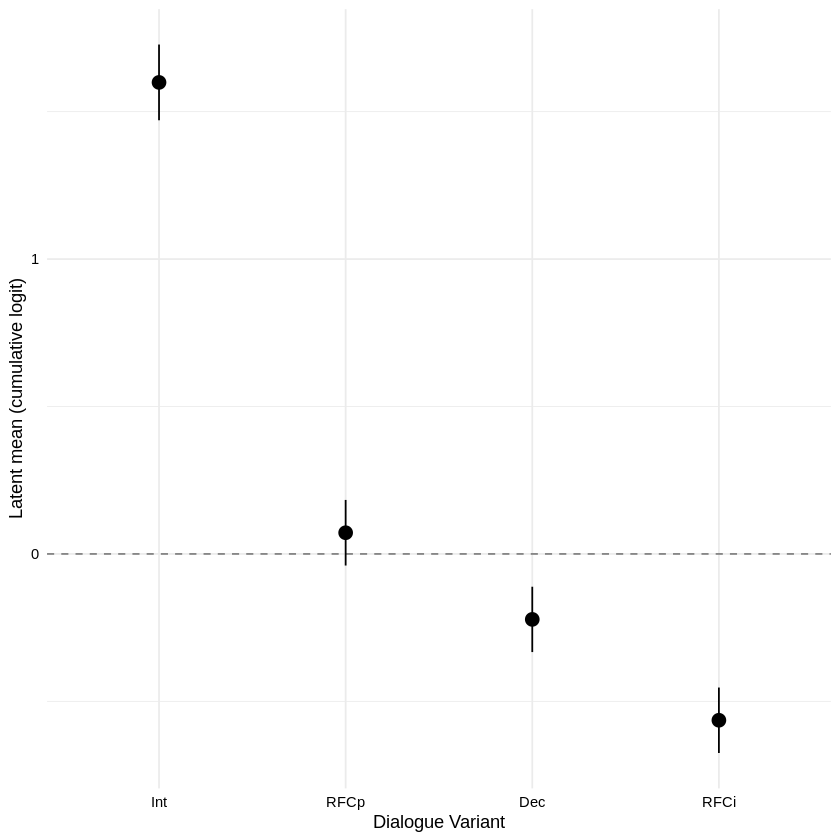

In [89]:
library(ggplot2)

# assuming latent_tbl has columns: condition, emmean, asymp.LCL, asymp.UCL
latent_tbl$condition <- factor(latent_tbl$condition, levels = c("Int","RFCp","Dec","RFCi"))

ggplot(latent_tbl, aes(x = condition, y = emmean)) +
  geom_hline(yintercept = 0, linetype = "dashed", color = "grey50") +
  geom_pointrange(aes(ymin = asymp.LCL, ymax = asymp.UCL), size = 0.7) +
  labs(x = "Dialogue Variant", y = "Latent mean (cumulative logit)") +
  theme_minimal() +
  theme(
    text = element_text(color = "black"),        # All text
    axis.title = element_text(color = "black"),  # Axis titles
    axis.text = element_text(color = "black"),   # Axis tick labels
    legend.text = element_text(color = "black"), # Legend text
    legend.title = element_text(color = "black"),# Legend title
    plot.title = element_text(color = "black")   # Plot title
  )

### Pairwise Comparison Summary


In [90]:
# Get the summary of the pairwise comparisons
results <- summary(pairs_holm, adjust = "holm")

# Convert the results to a dataframe
df_contrasts <- as.data.frame(results)

# Create a function to format P values
format_pvalue <- function(p_value) {
  if (p_value < 0.001) {
    return("<0.001***")
  } else if (p_value < 0.01) {
    return("<0.01**")
  } else if (p_value < 0.05) {
    return("<0.05*")
  } else {
    return(paste0("", round(p_value, 4)))
  }
}

# Create dataframe for pairwise comparisons
df_pairwise <- data.frame(
  Effect = df_contrasts$contrast,
  Coefficient = round(df_contrasts$estimate, 2),
  `Std. Error` = round(df_contrasts$SE, 2),
  `Z Value` = round(df_contrasts$z.ratio, 2),
  `P Value` = sapply(df_contrasts$p.value, format_pvalue),
  Odds_Ratio = round(exp(df_contrasts$estimate), 2),
  CI_Lower = round(exp(df_contrasts$estimate - 1.96 * df_contrasts$SE), 2), # Using 1.96 for 95% CI approximation
  CI_Upper = round(exp(df_contrasts$estimate + 1.96 * df_contrasts$SE), 2)  # Using 1.96 for 95% CI approximation
)

# Print the new pairwise dataframe
print(df_pairwise)

       Effect Coefficient Std..Error Z.Value   P.Value Odds_Ratio CI_Lower
1  Int - RFCp        1.53       0.09   17.61 <0.001***       4.61     3.89
2   Int - Dec        1.82       0.09   20.78 <0.001***       6.18     5.20
3  Int - RFCi        2.16       0.09   24.35 <0.001***       8.70     7.31
4  RFCp - Dec        0.29       0.08    3.69 <0.001***       1.34     1.15
5 RFCp - RFCi        0.64       0.08    7.95 <0.001***       1.89     1.61
6  Dec - RFCi        0.34       0.08    4.31 <0.001***       1.41     1.21
  CI_Upper
1     5.46
2     7.34
3    10.35
4     1.57
5     2.21
6     1.64


### Pairwise Comparison P-Values


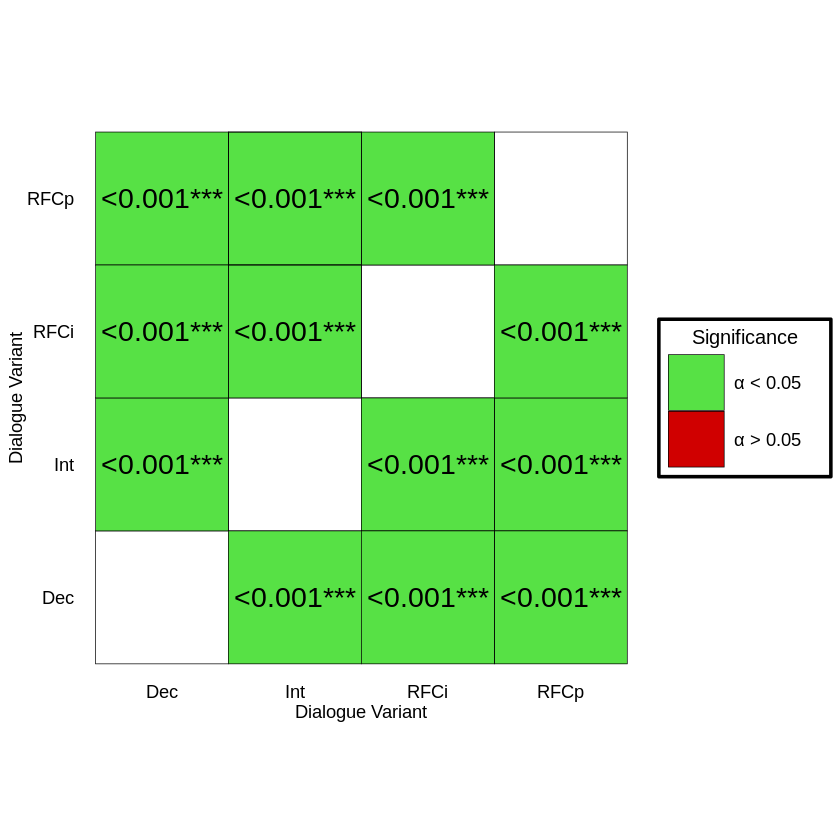

In [91]:


# Define all conditions
conditions <- c("Int", "RFCp", "Dec", "RFCi")

# Prepare pairwise data
df_pairs <- df_pairwise %>%
  mutate(
    x = sapply(strsplit(Effect, " - "), `[`, 1),
    y = sapply(strsplit(Effect, " - "), `[`, 2),
    Significance = ifelse(gsub("[^0-9.]", "", P.Value) < 0.05, "α < 0.05", "α > 0.05")
  ) %>%
  select(x, y, P.Value, Significance)

# Create full symmetric matrix
df_full <- expand.grid(
  x = conditions,
  y = conditions,
  stringsAsFactors = FALSE
) %>%
  left_join(df_pairs, by = c("x", "y")) %>%
  left_join(df_pairs %>% rename(x = y, y = x, P.Value2 = P.Value, Significance2 = Significance),
            by = c("x", "y")) %>%
  mutate(
    # Use original or mirrored values
    P.Value = coalesce(P.Value, P.Value2),
    Significance = coalesce(Significance, Significance2),
    x = factor(x, levels = conditions),
    y = factor(y, levels = conditions),
    EmptyCell = x == y  # Diagonal stays empty
  )

# Add a dummy off-diagonal row to force "α > 0.05" in the legend
if(!"α > 0.05" %in% df_full$Significance){
  dummy_row <- data.frame(
    x = conditions[1],
    y = conditions[2],  # off-diagonal, will not overlap actual diagonal
    P.Value = NA,
    Significance = factor("α > 0.05", levels = c("α < 0.05", "α > 0.05")),
    EmptyCell = FALSE
  )
  df_full <- bind_rows(df_full, dummy_row)
}

ggplot(df_full, aes(x = x, y = y)) +
  geom_tile(data = subset(df_full, EmptyCell), fill = "white", color = "black") +
  geom_tile(data = subset(df_full, !EmptyCell), aes(fill = Significance, alpha = !is.na(P.Value)), color = "black") +
  geom_text(data = subset(df_full, !EmptyCell & !is.na(P.Value)), aes(label = P.Value), size = 6, color = "black") +
  scale_fill_manual(
    values = c("α < 0.05" = "#57e145", "α > 0.05" = "#d00000"),
    name = "Significance",
    drop = FALSE
  ) +
  scale_alpha_identity() +
  coord_fixed() +
  guides(
    fill = guide_legend(
      override.aes = list(shape = 22, size = 6, color = "black", alpha = 1)
    )
  ) +
  labs(
    x = "Dialogue Variant",
    y = "Dialogue Variant"
  ) +
  theme_minimal() +
  theme(
    panel.grid = element_blank(),
    axis.text = element_text(size = 11, color = "black"),
    legend.title = element_text(size = 12, hjust = 0.5),
    legend.text = element_text(size = 11),
    legend.background = element_rect(color = "black", size = 1),
    legend.key.height = unit(1.2, "cm"),
    legend.key.width = unit(1.2, "cm"),
    legend.spacing.y = unit(0.2, "cm")
  )


## OIR

### Setup Data

In [92]:
# Read
df <- read.csv("https://raw.githubusercontent.com/MatthewCGalbraith/GrammarHCI/refs/heads/main/scoresnoncondensedlong.csv",
               na.strings = c("", "NA"))

# Keep OIR items
df_oir <- df %>% filter(grepl("^OIR[A-B]", Question))

# Scores as ordered 1..5; drop 0/NA
df_oir <- df_oir %>%
  mutate(Scores = as.character(Scores)) %>%
  filter(Scores %in% c("1","2","3","4","5")) %>%
  mutate(Scores = ordered(Scores, levels = c("1","2","3","4","5")))

# Map items to condition
df_oir <- df_oir %>%
  mutate(
    condition = case_when(
      grepl("^OIRA", Question) ~ "OIRi",  # implicit "huh?"
      grepl("^OIRB", Question) ~ "OIRp",  # explicit confirmation/tag
      TRUE ~ NA_character_
    ),
    condition = factor(condition, levels = c("OIRp","OIRi")) # display order
  )


### Frequency Table

In [93]:
# df_frequency_table <- df_oir %>%
#   group_by(condition, Scores) %>%
#   summarise(Frequency = n(), .groups = 'drop')

# print(df_frequency_table)

### Stacked Bar Chart

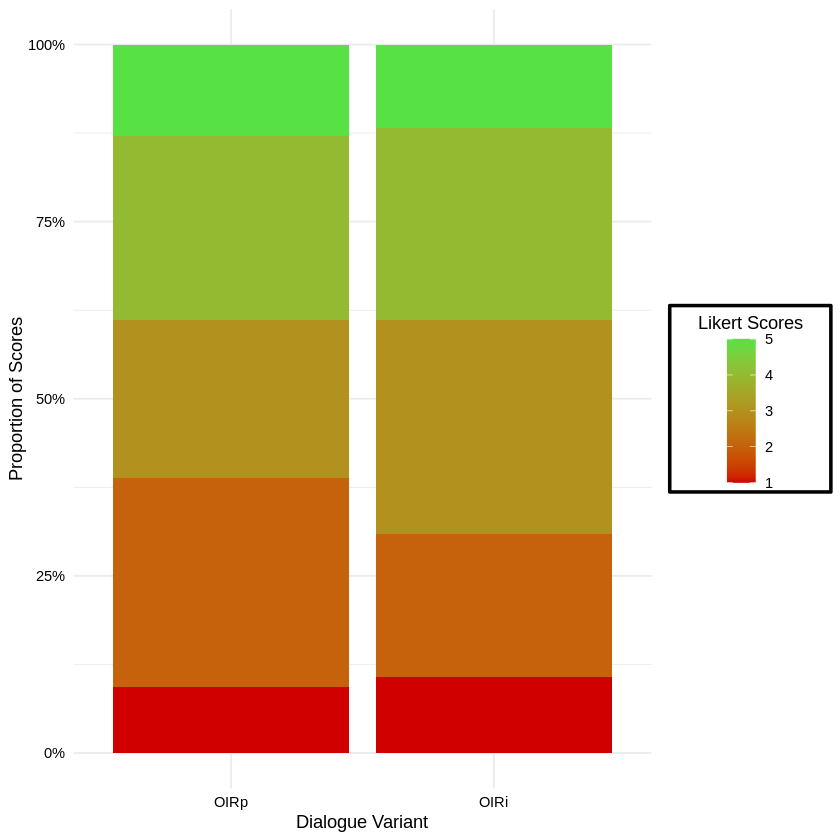

In [94]:
# Calculate proportions of Scores within each condition
df_proportions <- df_oir %>%
  group_by(condition, Scores) %>%
  summarise(count = n(), .groups = 'drop') %>%
  group_by(condition) %>%
  mutate(proportion = count / sum(count)) %>%
  ungroup()

# Convert Scores to numeric for gradient scale
df_proportions$Scores_numeric <- as.numeric(as.character(df_proportions$Scores))

# Create the 100% stacked bar chart with continuous gradient
ggplot(df_proportions, aes(x = condition, y = proportion, fill = Scores_numeric)) +
  geom_bar(stat = "identity", position = "fill") +
  #geom_text(aes(label = count), position = position_stack(vjust = 0.5), color = "black", size = 4) + # Added count labels
  scale_y_continuous(labels = scales::percent) +
  labs(
    title = NULL, # Removed the title
    x = "Dialogue Variant",
    y = "Proportion of Scores",
    fill = "Likert Scores"
  ) +
  # Continuous color scale from red (1) to green (5)
  scale_fill_gradient(low = "#d00000", high = "#57e145",
                      breaks = c(1, 2, 3, 4, 5),
                      labels = c("1", "2", "3", "4", "5")) +
  theme_minimal() +
  theme(
    axis.text.x = element_text(angle = 0, hjust = 0.5, color = "black"), # Horizontal and black
    axis.text.y = element_text(color = "black"), # Y-axis text black
    axis.title.x = element_text(color = "black"), # X-axis title black
    axis.title.y = element_text(color = "black"), # Y-axis title black
    legend.position = "right",
    legend.title = element_text(color = "black", hjust = 0.5), # Centered legend title
    legend.text = element_text(color = "black"), # Legend text black
    legend.background = element_rect(color = "black", linewidth = 1), # Black box around legend
    legend.justification = "center", # Center the legend vertically if position is right/left
    legend.box.just = "center" # Justify individual legends within box
  )

### EMMeans Analysis

In [95]:
# Model
m_oir <- clm(Scores ~ condition, data = df_oir, link = "logit", Hess = TRUE)

# Latent EMMeans with CIs
emm_latent_oir <- emmeans(m_oir, ~ condition, mode = "latent")
latent_oir_tbl <- as.data.frame(summary(emm_latent_oir, infer = c(TRUE, TRUE)))
write.csv(latent_oir_tbl, "OIR_condition_latent_emmeans.csv", row.names = FALSE)


### Pairwise Comparison

In [96]:
pairs_holm_oir  <- pairs(emm_latent_oir, adjust = "holm", reverse = TRUE)

pairs_holm_tbl  <- as.data.frame(summary(pairs_holm_oir, infer = c(TRUE, TRUE)))

write.csv(pairs_holm_tbl, "OIR_condition_pairs_holm.csv", row.names = FALSE)


### EMMeans Plot

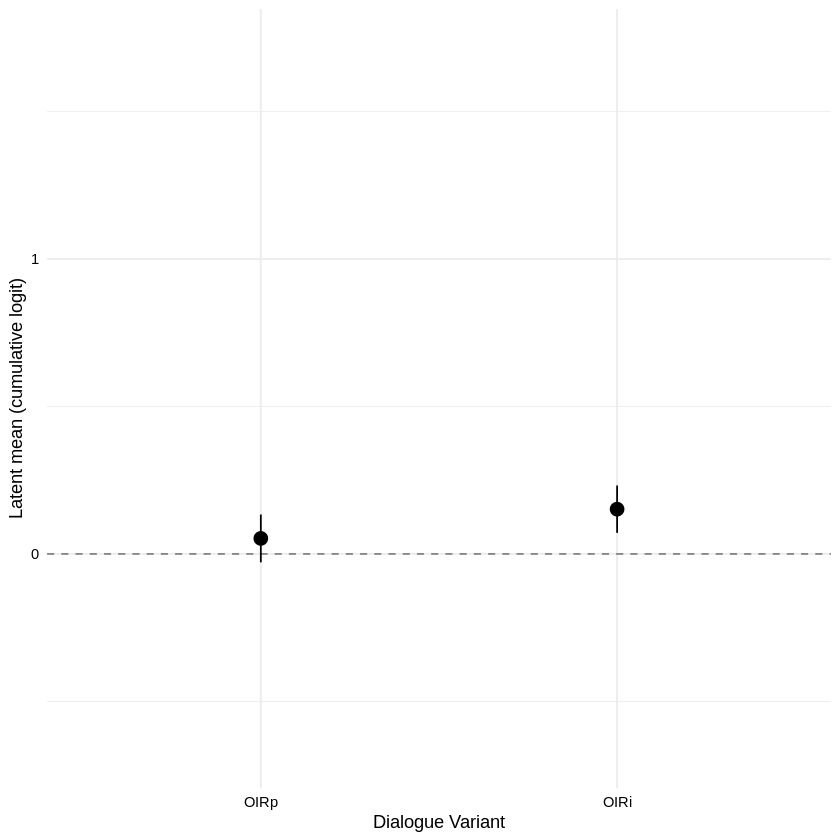

In [97]:
# Find y-axis limits from the first plot's data
ymin <- min(latent_tbl$asymp.LCL)
ymax <- max(latent_tbl$asymp.UCL)

latent_oir_tbl$condition <- factor(latent_oir_tbl$condition,
                                   levels = c("OIRp","OIRi"))

ggplot(latent_oir_tbl, aes(x = condition, y = emmean)) +
  geom_hline(yintercept = 0, linetype = "dashed", color = "grey50") +
  geom_pointrange(aes(ymin = asymp.LCL, ymax = asymp.UCL), size = 0.7) +
  labs(x = "Dialogue Variant", y = "Latent mean (cumulative logit)") +
  coord_cartesian(ylim = c(ymin, ymax)) +
  theme_minimal() +
  theme(
    text = element_text(color = "black"),        # All text
    axis.title = element_text(color = "black"),  # Axis titles
    axis.text = element_text(color = "black"),   # Axis tick labels
    legend.text = element_text(color = "black"), # Legend text
    legend.title = element_text(color = "black"),# Legend title
    plot.title = element_text(color = "black")   # Plot title
  )


### Pairwise Comparison Summary

In [98]:
# # Get the summary of the pairwise comparisons for OIR data
# results <- summary(pairs_holm_oir, adjust = "holm", reverse = TRUE)

# # Convert the results to a dataframe
# df_contrasts <- as.data.frame(results)

# # Create a function to format P values
# format_pvalue <- function(p_value) {
#   if (p_value < 0.001) {
#     return("<0.001***")
#   } else if (p_value < 0.01) {
#     return("<0.01**")
#   } else if (p_value < 0.05) {
#     return("<0.05*")
#   } else {
#     return(paste0("", round(p_value, 4)))
#   }
# }

# # Create dataframe for pairwise comparisons
# df_pairwise <- data.frame(
#   Effect = df_contrasts$contrast,
#   Coefficient = round(df_contrasts$estimate, 2),
#   `Std. Error` = round(df_contrasts$SE, 2),
#   `Z Value` = round(df_contrasts$z.ratio, 2),
#   `P Value` = sapply(df_contrasts$p.value, format_pvalue),
#   Odds_Ratio = round(exp(df_contrasts$estimate), 2),
#   CI_Lower = round(exp(df_contrasts$estimate - 1.96 * df_contrasts$SE), 2), # Using 1.96 for 95% CI approximation
#   CI_Upper = round(exp(df_contrasts$estimate + 1.96 * df_contrasts$SE), 2)  # Using 1.96 for 95% CI approximation
# )

# # Print the new pairwise dataframe
# print(df_pairwise)

### Pairwise Comparison P-Values

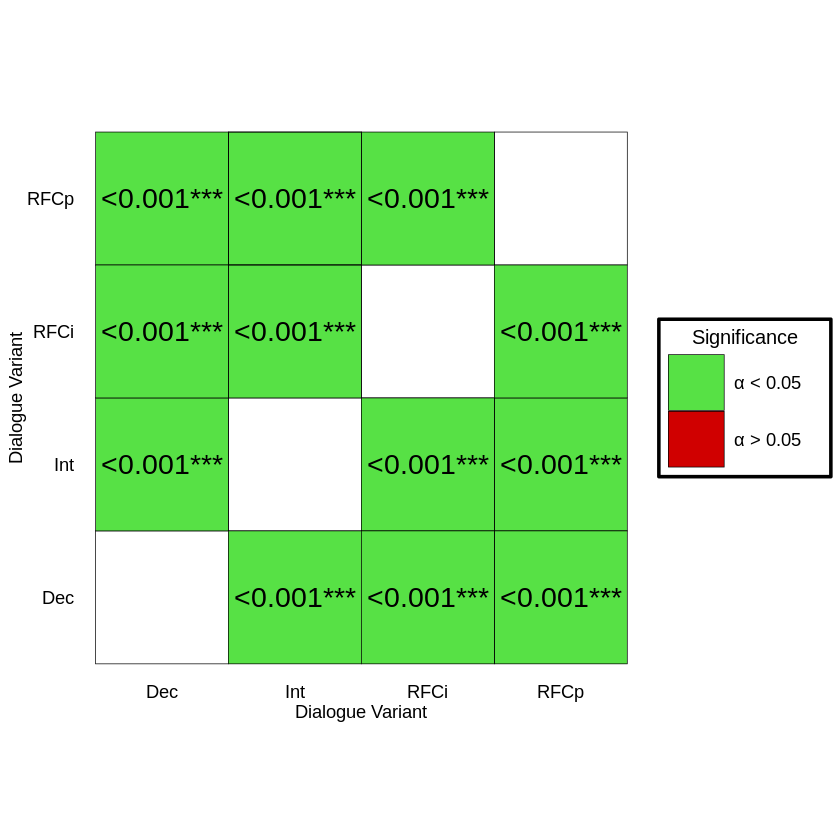

In [99]:
# Automatically get all conditions from your pairwise data
conditions <- unique(c(df_pairwise$Effect %>% sapply(function(x) strsplit(x, " - ")[[1]][1]),
                       df_pairwise$Effect %>% sapply(function(x) strsplit(x, " - ")[[1]][2])))

# Prepare pairwise data
df_pairs <- df_pairwise %>%
  mutate(
    x = sapply(strsplit(Effect, " - "), `[`, 1),
    y = sapply(strsplit(Effect, " - "), `[`, 2),
    Significance = ifelse(gsub("[^0-9.]", "", P.Value) < 0.05, "α < 0.05", "α > 0.05")
  ) %>%
  select(x, y, P.Value, Significance)

# Create full symmetric matrix
df_full <- expand.grid(
  x = conditions,
  y = conditions,
  stringsAsFactors = FALSE
) %>%
  left_join(df_pairs, by = c("x", "y")) %>%
  left_join(df_pairs %>% rename(x = y, y = x, P.Value2 = P.Value, Significance2 = Significance),
            by = c("x", "y")) %>%
  mutate(
    # Use original or mirrored values
    P.Value = coalesce(P.Value, P.Value2),
    Significance = coalesce(Significance, Significance2),
    x = factor(x, levels = conditions),
    y = factor(y, levels = conditions),
    EmptyCell = x == y  # Diagonal stays empty
  )

# Ensure both legend levels are present with invisible dummy tiles
required_levels <- c("α < 0.05", "α > 0.05")
missing_levels <- setdiff(required_levels, df_full$Significance)

if(length(missing_levels) > 0){
  dummy_rows <- data.frame(
    x = conditions[1],
    y = conditions[2],  # off-diagonal
    P.Value = NA,
    Significance = factor(missing_levels, levels = required_levels),
    EmptyCell = FALSE
  )
  df_full <- bind_rows(df_full, dummy_rows)
}

# Plot symmetric heatmap
ggplot(df_full, aes(x = x, y = y)) +
  geom_tile(data = subset(df_full, EmptyCell), fill = "white", color = "black") +
  geom_tile(data = subset(df_full, !EmptyCell), aes(fill = Significance, alpha = !is.na(P.Value)), color = "black") +
  geom_text(data = subset(df_full, !EmptyCell & !is.na(P.Value)), aes(label = P.Value), size = 6, color = "black") +
  scale_fill_manual(
    values = c("α < 0.05" = "#57e145", "α > 0.05" = "#d00000"),
    name = "Significance",
    drop = FALSE
  ) +
  scale_alpha_identity() +
  coord_fixed() +
  guides(
    fill = guide_legend(
      override.aes = list(shape = 22, size = 6, color = "black", alpha = 1)
    )
  ) +
  labs(
    x = "Dialogue Variant",
    y = "Dialogue Variant"
  ) +
  theme_minimal() +
  theme(
    panel.grid = element_blank(),
    axis.text = element_text(size = 11, color = "black"),
    legend.title = element_text(size = 12, hjust = 0.5),
    legend.text = element_text(size = 11),
    legend.background = element_rect(color = "black", size = 1),
    legend.key.height = unit(1.2, "cm"),
    legend.key.width = unit(1.2, "cm"),
    legend.spacing.y = unit(0.2, "cm")
  )


### Pairwise Comparison Estimates

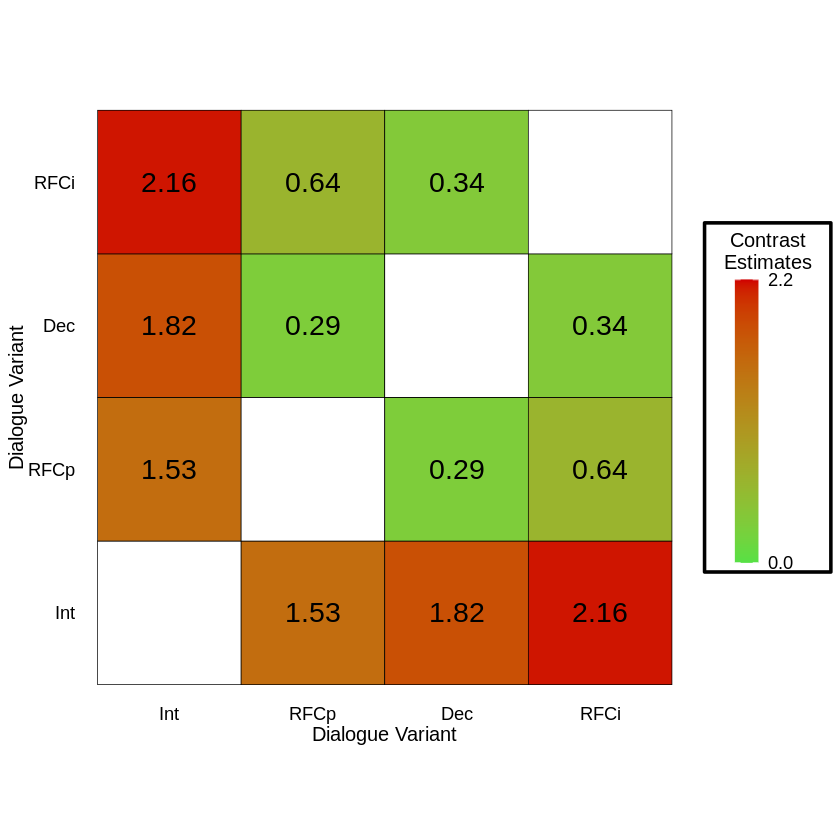

In [100]:
# Split Effect into two conditions
df_heat_coef <- df_pairwise %>%
  mutate(Effect = as.character(Effect)) %>%
  separate(Effect, into = c("Condition1", "Condition2"), sep = " - ") %>%
  rename(Coefficient = Coefficient)

# Get all unique conditions
all_conditions <- unique(c(df_heat_coef$Condition1, df_heat_coef$Condition2))

# Create a full grid of all condition pairs
full_grid <- expand.grid(
  Condition1 = all_conditions,
  Condition2 = all_conditions
)

# Join the actual coefficients onto the grid
df_heat_coef_full <- full_grid %>%
  left_join(df_heat_coef, by = c("Condition1", "Condition2")) %>%
  # Add reversed pairs if missing (for symmetry)
  mutate(
    Coefficient = ifelse(
      is.na(Coefficient),
      df_heat_coef$Coefficient[
        match(
          paste(Condition2, Condition1, sep = "-"),
          paste(df_heat_coef$Condition1, df_heat_coef$Condition2, sep = "-")
        )
      ],
      Coefficient
    )
  )

# Optional: blank out diagonal (self-comparisons)
df_heat_coef_full <- df_heat_coef_full %>%
  mutate(Coefficient = ifelse(Condition1 == Condition2, NA, Coefficient))

# Make factors for axes
df_heat_coef_full <- df_heat_coef_full %>%
  mutate(
    Condition1 = factor(Condition1, levels = all_conditions),
    Condition2 = factor(Condition2, levels = all_conditions)
  )

# Plot heatmap
ggplot(df_heat_coef_full, aes(x = Condition1, y = Condition2, fill = Coefficient)) +
  geom_tile(color = "black") +
  geom_text(aes(label = round(Coefficient, 2)), size = 6, na.rm = TRUE) +
  scale_fill_gradient(
    name = "Contrast\nEstimates",
    low = "#57e145",
    high = "#d00000",
    limits = c(0.0, 2.2),          # force legend range
    breaks = c(0.0, 2.2),          # only endpoints
    labels = c("0.0", "2.2"),      # only labels
    oob = squish,
    na.value = "white"
  ) +
  labs(x = "Dialogue Variant", y = "Dialogue Variant") + # Add x and y axis titles
  coord_fixed() +
  theme_minimal() +
  theme(
    panel.grid = element_blank(),
    axis.title.x = element_text(size = 12, color = "black"), # X-axis title black
    axis.title.y = element_text(size = 12, color = "black"), # Y-axis title black
    axis.text = element_text(size = 11, color = "black"),
    legend.title = element_text(size = 12, hjust = 0.5), # Centered legend title
    legend.text = element_text(size = 11),
    legend.background = element_rect(color = "black", size = 1),
    legend.key.height = unit(1.2, "cm"),
    legend.key.width = unit(0.5, "cm"),
    legend.spacing.y = unit(0.2, "cm"),
    legend.position = "right",    # Keep legend on right
    legend.justification = "center" # Center legend vertically when on right
  )